In [1]:
import numpy as np
import sympy as sp
from sympy.plotting import plot
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math
def eq_disp(varstring, expr):
    display(Latex(f"${varstring}={sp.latex(expr)}$"))

def reduce_feedback(G_fwd, G_bwd):
    """Assumes feedback is deducted from signal, if not
    change sign of feedback"""
    return sp.simplify(G_fwd/(1+G_fwd*G_bwd))

s = sp.symbols('s')
t, zeta, omega = sp.symbols('t, zeta, omega', positive=True, real=True)

From the Transfer function we extract $\omega_n$ and $\zeta$

In [2]:
omega = sp.sqrt(7)
zeta = sp.Rational(3175, 1000)/2/omega
R = 1/s
T = omega**2/(s**2 + 2*zeta*omega*s + omega**2)
Y = R*T
eq_disp('Y(s)', Y)

<IPython.core.display.Latex object>

The formula for percent overshoot is:
$$\sigma_p \%=\frac{y\left(T_p\right)-y(\infty)}{y(\infty)} \times 100 \%$$
where 
$$\left.\frac{d y(t)}{d t}\right|_{t=T_p}=\left.0\right|_{(\text {first })}$$
First we must find y(t)

We can construct the partial fractions according to:
$$T(s)R(s)=\frac{K_{s 1}}{s+s_1}+\frac{K_{s 2}}{s+s_2}+\cdots+\frac{K_{s n}}{s+s_n}$$
First solve for the n poles 

In [3]:
p, q = Y.as_numer_denom()
poles = sp.solve(q,s)
        
for i, pole in enumerate(poles):
    eq_disp(f'-s_{i}', pole)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Now we find the numerators $K_{s_i}$

In [4]:
K_s = []
p_fracs = []
y = 0

conjugates = set()

for i, pole in enumerate(poles):
    if pole in conjugates:
        continue
    Ki = sp.simplify(p/np.prod([(x+pole) for x in poles if x != pole])).subs(s, pole)
    if pole.is_real:
        y += sp.inverse_laplace_transform(Ki/(s-pole), s, t)
    else:
        alpha = sp.re(Ki)
        beta = abs(sp.im(Ki))
        theta = sp.atan2(sp.re(Ki), sp.im(Ki)).evalf()
        r = sp.sqrt(beta**2 + alpha**2)
        y += 2*r*sp.exp(-alpha*t)*sp.cos(beta*t + theta)
        conjugates.add(sp.re(pole)-sp.I*sp.im(pole))

y = y.evalf(5)
eq_disp('y(y)',y)

<IPython.core.display.Latex object>

From the partial fraction expansion we can take the inverse laplace transform

y = sp.inverse_laplace_transform(Y, s,t)
y

Transform to the time domain

In [5]:
dy = y.diff(t)
dy

-10.498*sqrt(28671)*exp(-20*t)*sin(20*sqrt(28671)*t/127 + 2.49806829346609) - 1333.3*exp(-20*t)*cos(20*sqrt(28671)*t/127 + 2.49806829346609)

In [6]:
sp.N(dy)

-1777.63483664948*exp(-20*t)*sin(20*sqrt(28671)*t/127 + 2.49806829346609) - 1333.291015625*exp(-20*t)*cos(20*sqrt(28671)*t/127 + 2.49806829346609)

Peak time is then calculated

In [17]:
sol = sp.solve(dy.evalf(5), t)
Tp = min([x for x in sol if x != 0])
eq_disp('T_p', sp.N(Tp,3))

ValueError: min() arg is an empty sequence

Now the steady state value is calculated by 
$$\lim_{t\rightarrow\infty}y(t)$$

In [ ]:
y_ss = sp.limit(y, t, sp.oo)
eq_disp('y(\infty)', y_ss)

<IPython.core.display.Latex object>

Finally %overshoot can be calculated

In [ ]:
sigma_p = ((y.subs(t, Tp) - y_ss)/y_ss*100).evalf()
eq_disp('\\sigma_p\%', sp.N(sigma_p,3))


<IPython.core.display.Latex object>

The setling time at 2% threshold is calculated by:
$$
T_s=4 \tau=\frac{4}{\xi \omega_n}
$$

In [ ]:
Ts = 4/(zeta*omega)
eq_disp('T_s', sp.N(Ts,3))

<IPython.core.display.Latex object>

## b)

To verify our results we plot $y(t)$ and anotate the plot with the peak time $T_p$ and the settling time $T_s$ 

NameError: name 'Ts' is not defined

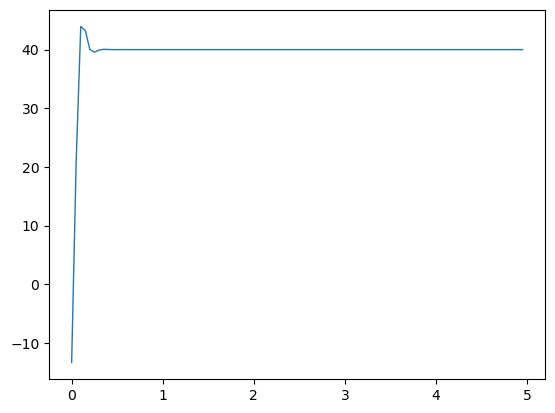

In [8]:
y_f = sp.lambdify(t, y)
tspan = np.r_[0:5:0.05]
plt.plot(tspan, y_f(tspan), linewidth=1)
plt.plot(float(Ts), y_f(float(Ts)),linestyle='None', markersize=7, marker='x')
plt.plot(float(Tp), y_f(float(Tp)),linestyle='None', markersize=7, marker='x')
plt.plot(tspan, float(y_ss)*np.ones(len(tspan)), 'k.', markersize=1)
plt.legend(['$y(t)$', '$T_s$', '$T_p$', '$y_{ss}$'])
plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.title('unit step response')
plt.show()

# P5.22

## a)

In [ ]:
K, s, tau = sp.symbols('K, s, tau')
tau = sp.Rational(243,100)
GcG = 2/(s+sp.Rational(2,10)*K)
H = 2/(2*s + tau)

First we simplify the system to a single transferfunction

In [ ]:
T = reduce_feedback(GcG, H)
eq_disp('T', T)

<IPython.core.display.Latex object>

Now since 
$$Y(s) = T(s)R(s)$$
$$E(s) = R-Y = (1-T(s))R$$
now since $R(s) = \frac{1}{s}$ we get (using final value theorem):
$$e_{ss} = \lim_{t\rightarrow \infty}E(t) =s\lim_{t\rightarrow 0}E(s) = (1-T(s))$$

In [ ]:
e_ss = 1-sp.limit(T, s, 0)
eq_disp('e_{ss}', e_ss)

<IPython.core.display.Latex object>

Now we can solve for $K$ such that $e_{ss}=0$

In [ ]:
K_ss0 = sp.solve(e_ss, K)[0]
eq_disp('K', sp.N(K_ss0,3))

<IPython.core.display.Latex object>

## b)

In [ ]:
T = T.subs(K, K_ss0)
R = 1/s
Y = sp.simplify(T*R)
eq_disp('Y', Y)

<IPython.core.display.Latex object>

Now we find the numerators $K_{s_i}$

Transform to the time domain

In [ ]:
y=0
for term in sp.Add.make_args(Y.apart(s)):
    y += sp.inverse_laplace_transform(term, s, t)
sp.N(y,3)

5.83e-11*(1.55e+10*sin(sqrt(17144341199)*t/97200) - 1.71e+10*cos(sqrt(17144341199)*t/97200))*exp(-76249*t/97200) + 1.0

In [ ]:
dy = y.diff(t)
sp.N(dy,3)

-0.784*(0.902*sin(sqrt(17144341199)*t/97200) - cos(sqrt(17144341199)*t/97200))*exp(-76249*t/97200) + (1.35*sin(sqrt(17144341199)*t/97200) + 1.22*cos(sqrt(17144341199)*t/97200))*exp(-76249*t/97200)

Peak time is then calculated

In [ ]:
from scipy.optimize import minimize
Tp = min([x for x in sol if x != 0])
eq_disp('T_p', sp.N(Tp,3))

<IPython.core.display.Latex object>

Now the steady state value is calculated by 
$$\lim_{t\rightarrow\infty}y(t)$$

In [ ]:
y_ss = sp.limit(y, t, sp.oo)
eq_disp('y(\infty)', y_ss)

<IPython.core.display.Latex object>

Finally %overshoot can be calculated

In [ ]:
sigma_p = (y.subs(t, Tp) - y_ss)/y_ss*100
eq_disp('\\sigma_p\%', sp.N(sigma_p,3))

<IPython.core.display.Latex object>